### Libraries

In [1]:
#%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import random
import os
import time
from utils import *

In [3]:
#!pip install ipympl

In [4]:
print("Pytorch version: ... {} ".format(torch.__version__))
print("Python version ... {}".format(sys.version))

Pytorch version: ... 2.0.0+cu117 
Python version ... 3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]


In [5]:
# compute epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Generate Trajectory-based Dataset

In [7]:
"""
(2) 2DoF: = Planar2D, TwoLink
(2) 3DoF: = Planar3R, Planar2RP
(2) 4DoF: = Cobra600 (Scara), Orion5,
(10) 6DoF: = Jaco, Puma560, Mico, IRB140, KR5, UR10, UR3, UR5, Puma260, Stanford
(7) 7DoF: = Jaco2, Panda, GP66+1, WAM, Baxter, Sawyer, Kuka LWR4+, PR2 (Right Arm)
(1) 8DoF: = P8, 
(1) 10DoF: = Ball, Coil 

"""



# seed random generator
torch.manual_seed(0)

# choose robot alongside joint limits
"""

robot_list = ["6DoF-6R-Jaco", "6DoF-6R-Puma560", "6DoF-6R-Mico", "6DoF-6R-IRB140", "6DoF-6R-KR5", 
              "6DoF-6R-UR10", "6DoF-6R-UR3", "6DoF-6R-UR5", "6DoF-6R-Puma260", "6DoF-2RP3R-Stanford"]

robot_list = ["6DoF-6R-Jaco", "6DoF-6R-Puma560", "6DoF-6R-Mico", "6DoF-6R-IRB140", "6DoF-6R-KR5", 
              "6DoF-6R-UR10", "6DoF-6R-UR3", "6DoF-6R-UR5", "6DoF-6R-Puma260", "6DoF-2RP3R-Stanford"]

robot_list = ["6DoF-2RP3R-Stanford"]

"""

robot_list_6 = ["6DoF-6R-Jaco", "6DoF-6R-Puma560", "6DoF-6R-Mico", "6DoF-6R-IRB140", "6DoF-6R-KR5", 
              "6DoF-6R-UR10", "6DoF-6R-UR3", "6DoF-6R-UR5", "6DoF-6R-Puma260", "6DoF-2RP3R-Stanford"]

robot_list_7 = ["7DoF-7R-Jaco2", "7DoF-7R-Panda", "7DoF-7R-WAM", "7DoF-7R-Baxter", "7DoF-7R-Sawyer", 
              "7DoF-7R-KukaLWR4+", "7DoF-7R-PR2Arm", "7DoF-7R-PA10", "7DoF-7R-Gen3", "7DoF-2RP4R-GP66+1"]

#robot_list = robot_list_6 + robot_list_7
robot_list = ["7DoF-7R-Panda"]



#robot_list = ["7DoF-7R-Panda","7DoF-GP66"]
#for js in range(22,52,2):

#for js in range(2,22,2):
for js in range(1,2):
    
    for r in robot_list:

        robot_choice = r
        print('Generating samples for: {}'.format(robot_choice))
        #robot_choice = "7DoF-7R-Panda"  #"7DoF-7R-Panda, "7DoF-GP66", "8DoF-P8"

        if robot_choice == "6DoF-6R-Jaco":
            # https://docs.quanser.com/quarc/documentation/kinova_jaco_read_block.html
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(42)), torch.deg2rad(torch.tensor(318))],
                                  [torch.deg2rad(torch.tensor(17)), torch.deg2rad(torch.tensor(343))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))]])

            robot_type = "C"

        elif robot_choice == "6DoF-6R-Puma560":

            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-160)), torch.deg2rad(torch.tensor(160))],
                                  [torch.deg2rad(torch.tensor(-110)), torch.deg2rad(torch.tensor(110))],
                                  [torch.deg2rad(torch.tensor(-135)), torch.deg2rad(torch.tensor(135))],
                                  [torch.deg2rad(torch.tensor(-266)), torch.deg2rad(torch.tensor(266))],
                                  [torch.deg2rad(torch.tensor(-100)), torch.deg2rad(torch.tensor(100))],
                                  [torch.deg2rad(torch.tensor(-266)), torch.deg2rad(torch.tensor(266))]])

            robot_type = "C"


        elif robot_choice == "6DoF-6R-Mico":
            # https://docs.quanser.com/quarc/documentation/kinova_6dof_mico_write_block.html
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(50)), torch.deg2rad(torch.tensor(310))],
                                  [torch.deg2rad(torch.tensor(25)), torch.deg2rad(torch.tensor(335))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))]])

            robot_type = "C"


        elif robot_choice == "6DoF-6R-IRB140":
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(180))],
                                  [torch.deg2rad(torch.tensor(-100)), torch.deg2rad(torch.tensor(100))],
                                  [torch.deg2rad(torch.tensor(-220)), torch.deg2rad(torch.tensor(60))],
                                  [torch.deg2rad(torch.tensor(-200)), torch.deg2rad(torch.tensor(200))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-400)), torch.deg2rad(torch.tensor(400))]])

            robot_type = "C"


        elif robot_choice == "6DoF-6R-KR5":
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-155)), torch.deg2rad(torch.tensor(155))],
                                  [torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(65))],
                                  [torch.deg2rad(torch.tensor(-15)), torch.deg2rad(torch.tensor(158))],
                                  [torch.deg2rad(torch.tensor(-350)), torch.deg2rad(torch.tensor(350))],
                                  [torch.deg2rad(torch.tensor(-130)), torch.deg2rad(torch.tensor(130))],
                                  [torch.deg2rad(torch.tensor(-350)), torch.deg2rad(torch.tensor(350))]])

            robot_type = "C"


        elif robot_choice == "6DoF-6R-UR10":
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))]])

            robot_type = "C"


        elif robot_choice == "6DoF-6R-UR3":
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))]])

            robot_type = "C"


        elif robot_choice == "6DoF-6R-UR5":
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))]])

            robot_type = "C"


        elif robot_choice == "6DoF-6R-Puma260":
            # https://medesign.seas.upenn.edu/index.php/Guides/PUMA260
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(110))],
                                  [torch.deg2rad(torch.tensor(-75)), torch.deg2rad(torch.tensor(240))],
                                  [torch.deg2rad(torch.tensor(-235)), torch.deg2rad(torch.tensor(60))],
                                  [torch.deg2rad(torch.tensor(-580)), torch.deg2rad(torch.tensor(40))],
                                  [torch.deg2rad(torch.tensor(-30)), torch.deg2rad(torch.tensor(200))],
                                  [torch.deg2rad(torch.tensor(-215)), torch.deg2rad(torch.tensor(295))]])

            robot_type = "C"

        elif robot_choice == "6DoF-2RP3R-Stanford":

            q_lim_o = torch.tensor([[torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.tensor(0.0), torch.tensor(0.8)],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(90))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))]])

            robot_type = "I"


        elif robot_choice == "7DoF-7R-Jaco2":    
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(42)), torch.deg2rad(torch.tensor(318))],
                                  [torch.deg2rad(torch.tensor(17)), torch.deg2rad(torch.tensor(343))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))]])

            robot_type = "C" 

        elif robot_choice == "7DoF-7R-Panda":    
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-166)), torch.deg2rad(torch.tensor(166))],
                                      [torch.deg2rad(torch.tensor(-101)), torch.deg2rad(torch.tensor(101))],
                                      [torch.deg2rad(torch.tensor(-166)), torch.deg2rad(torch.tensor(166))],
                                      [torch.deg2rad(torch.tensor(-176)), torch.deg2rad(torch.tensor(-4))],
                                      [torch.deg2rad(torch.tensor(-166)), torch.deg2rad(torch.tensor(166))],
                                      [torch.deg2rad(torch.tensor(-1)), torch.deg2rad(torch.tensor(215))],
                                      [torch.deg2rad(torch.tensor(-166)), torch.deg2rad(torch.tensor(166))]])

            robot_type = "C"


        elif robot_choice == "7DoF-WAM":

            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))]])

            robot_type = "C"

        elif robot_choice == "7DoF-Baxter":

            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-97.5)), torch.deg2rad(torch.tensor(97.5))],
                                  [torch.deg2rad(torch.tensor(-123)), torch.deg2rad(torch.tensor(60))],
                                  [torch.deg2rad(torch.tensor(-175)), torch.deg2rad(torch.tensor(175))],
                                  [torch.deg2rad(torch.tensor(-2.9)), torch.deg2rad(torch.tensor(150))],
                                  [torch.deg2rad(torch.tensor(-175.3)), torch.deg2rad(torch.tensor(175.3))],
                                  [torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-175.3)), torch.deg2rad(torch.tensor(175.3))]])

            robot_type = "C"



        elif robot_choice == "7DoF-7R-Sawyer":

            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-174.7)), torch.deg2rad(torch.tensor(174.7))],
                                  [torch.deg2rad(torch.tensor(-218.3)), torch.deg2rad(torch.tensor(130.2))],
                                  [torch.deg2rad(torch.tensor(-174.3)), torch.deg2rad(torch.tensor(174.3))],
                                  [torch.deg2rad(torch.tensor(-174.4)), torch.deg2rad(torch.tensor(174.4))],
                                  [torch.deg2rad(torch.tensor(-170.5)), torch.deg2rad(torch.tensor(170.5))],
                                  [torch.deg2rad(torch.tensor(-170.5)), torch.deg2rad(torch.tensor(170.5))],
                                  [torch.deg2rad(torch.tensor(-270)), torch.deg2rad(torch.tensor(270))]])

            robot_type = "C"


        elif robot_choice == "7DoF-7R-KukaLWR4+":

            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-175)), torch.deg2rad(torch.tensor(175))]])

            robot_type = "C"


        elif robot_choice == "7DoF-PR2-RightArm":    
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-130)), torch.deg2rad(torch.tensor(40))],
                                  [torch.deg2rad(torch.tensor(60)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-224)), torch.deg2rad(torch.tensor(44))],
                                  [torch.deg2rad(torch.tensor(0)), torch.deg2rad(torch.tensor(133))],
                                  [torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(180))],
                                  [torch.deg2rad(torch.tensor(0)), torch.deg2rad(torch.tensor(130))],
                                  [torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(180))]])

            robot_type = "C"

        elif robot_choice == "7DoF-7R-PA10":

            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(180))],
                                  [torch.deg2rad(torch.tensor(-135)), torch.deg2rad(torch.tensor(135))],
                                  [torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(180))],
                                  [torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(180))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(180))]])

            robot_type = "C"

        elif robot_choice == "7DoF-7R-Gen3":

            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-129)), torch.deg2rad(torch.tensor(129))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-148)), torch.deg2rad(torch.tensor(148))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))]])

            robot_type = "C"



        elif robot_choice == "7DoF-2RP4R-GP66+1":
            """
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  #[torch.tensor(0.3), torch.tensor(1.27)],
                                  [torch.tensor(-1.27), torch.tensor(-0.3)],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(90))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))]])
            """

            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(90))],
                                  [torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(90))],
                                  [torch.tensor(-0.6), torch.tensor(0.7)],
                                  #[torch.tensor(-1.27), torch.tensor(-0.3)],
                                  [torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(90))],
                                  [torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(90))],
                                  [torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(90))],
                                  [torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(90))]])

            robot_type = "I"



        elif robot_choice == "8DoF-P8":    
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-1)), torch.deg2rad(torch.tensor(1))],
                                  [torch.deg2rad(torch.tensor(-1)), torch.deg2rad(torch.tensor(1))],
                                  [torch.deg2rad(torch.tensor(-160)), torch.deg2rad(torch.tensor(160))],
                                  [torch.deg2rad(torch.tensor(-110)), torch.deg2rad(torch.tensor(110))],
                                  [torch.deg2rad(torch.tensor(-135)), torch.deg2rad(torch.tensor(135))],
                                  [torch.deg2rad(torch.tensor(-266)), torch.deg2rad(torch.tensor(266))],
                                  [torch.deg2rad(torch.tensor(-100)), torch.deg2rad(torch.tensor(100))],
                                  [torch.deg2rad(torch.tensor(-266)), torch.deg2rad(torch.tensor(266))]])

            robot_type = "I"


        #q_lim = q_lim/scale
        scale = 10
        q_lim = q_lim*(scale/10)

        print("\njoint limits for scale {}:\n{}".format(scale/10, q_lim))

        t0 = torch.distributions.uniform.Uniform(q_lim[:,0], q_lim[:,1]).sample()
        DH = get_DH(robot_choice, t0)
        print('DH:\n', DH)



        print("\njoint range {}:\n".format(js))

        # generate dataset with a specified number of samples
        n_traj = 50000
        n_traj_steps = 100
        n_samples = n_traj*n_traj_steps
        print_steps = 10
        data_position = []
        for s in range(n_traj):
            t0 = torch.distributions.uniform.Uniform(q_lim[:,0], q_lim[:,1]).sample()
            DH = get_DH(robot_choice, t0)
            T = forward_kinematics(DH)
            R = T[:3,:3]       
            rpy = matrix_to_euler_angles(R, "XYZ")
            #data_position.append(torch.cat([T[:3,-1], rpy, t0]).numpy())  

            D_current = torch.cat([T[:3,-1], rpy])
            Q_current = t0

            #print(t0)
            t = t0.clone()
            #print(D_current)
            for i in range(n_traj_steps):
                if robot_type == "C":
                    t += torch.deg2rad(torch.tensor(js)) # 0.5 
                elif robot_type == "I": # and robot_choice == "7DoF-GP66" or :
                    t[:2] += torch.deg2rad(torch.tensor(js)) # 0.5 
                    t[2] += torch.tensor(js/1000)
                    t[3:] += torch.deg2rad(torch.tensor(js)) # 0.5 
                DH = get_DH(robot_choice, t)
                T = forward_kinematics(DH)
                R = T[:3,:3]       
                rpy = matrix_to_euler_angles(R, "XYZ")

                D_previous = D_current.clone()
                Q_previous = Q_current.clone()
                D_current = torch.cat([T[:3,-1], rpy])
                Q_current = t.clone()

                data_position.append(torch.cat([D_previous, Q_previous, D_current, Q_current]).numpy()) 

                #sys.exit()


            if s%(n_traj/print_steps) == 0:
                print("Generated [{}] trajectories with {} samples...".format(s, i+1))

        data_position_a = np.array(data_position)

        # save dataset
        #if robot_choice == "6DoF-7R-Panda" or "7DoF-GP66":
        """
        header = ["x_p", "y_p", "z_p","R_p","P_p","Y_p",
                  "t1_p", "t2_p", "t3_p", "t4_p", "t5_p", "t6_p", 
                  "x_c", "y_c", "z_c","R_c","P_c","Y_c",
                  "t1_c", "t2_c", "t3_c", "t4_c", "t5_c", "t6_c"]
        """

        if robot_choice in robot_list_6:
            header = ["x_p", "y_p", "z_p","R_p","P_p","Y_p",
                      "t1_p", "t2_p", "t3_p", "t4_p", "t5_p", "t6_p",
                      "x_c", "y_c", "z_c","R_c","P_c","Y_c",
                      "t1_c", "t2_c", "t3_c", "t4_c", "t5_c", "t6_c"]


        elif robot_choice in robot_list_7:
            header = ["x_p", "y_p", "z_p","R_p","P_p","Y_p",
                      "t1_p", "t2_p", "t3_p", "t4_p", "t5_p", "t6_p", "t7_p",
                      "x_c", "y_c", "z_c","R_c","P_c","Y_c",
                      "t1_c", "t2_c", "t3_c", "t4_c", "t5_c", "t6_c", "t7_c"]


        """    
        if robot_choice == "7DoF-7R-Panda" or robot_choice == "7DoF-GP66":
            header = ["x_p", "y_p", "z_p","R_p","P_p","Y_p",
                      "t1_p", "t2_p", "t3_p", "t4_p", "t5_p", "t6_p", "t7_p",
                      "x_c", "y_c", "z_c","R_c","P_c","Y_c",
                      "t1_c", "t2_c", "t3_c", "t4_c", "t5_c", "t6_c", "t7_c"]

        if robot_choice =="8DoF-P8":
            header = ["x_p", "y_p", "z_p","R_p","P_p","Y_p",
                      "t1_p", "t2_p", "t3_p", "t4_p", "t5_p", "t6_p", "t7_p", "t8_p",
                      "x_c", "y_c", "z_c","R_c","P_c","Y_c",
                      "t1_c", "t2_c", "t3_c", "t4_c", "t5_c", "t6_c", "t7_c", "t8_c"]
        """


        df = pd.DataFrame(data_position_a)
        n_samples = data_position_a.shape[0]

        """
        path = "~/Documents/Research/WCCI2024/"
        df.to_csv(path+"datasets/"+robot_choice+"/data_"+robot_choice+"_"+str(n_samples)+"_qlim_scale_"+str(int(scale))+"_seq.csv",
                  index=False,
                  header=header)
        """

        df = pd.DataFrame(data_position_a)  # "datasets/"+robot_choice+"/
        #df.to_csv("traj_steps/review_data_"+robot_choice+"_"+str(n_samples)+"_qlim_scale_"+str(int(scale))+"_seq_"+str(js)+".csv",
        df.to_csv("../for_docker/left-out-datasets/7DoF-Combined/diffik_data_"+robot_choice+"_"+str(n_samples)+"_qlim_scale_"+str(int(scale))+"_seq_"+str(js)+".csv",
                  index=False,
                  header=header)

        



        data_position_a[:,:3] = data_position_a[:,:3] * 1000

        print("Data generation done for {}! - {} samples with {} joint step\n".format(robot_choice, n_samples, js))

Generating samples for: 7DoF-7R-Panda

joint limits for scale 1.0:
tensor([[-2.8972,  2.8972],
        [-1.7628,  1.7628],
        [-2.8972,  2.8972],
        [-3.0718, -0.0698],
        [-2.8972,  2.8972],
        [-0.0175,  3.7525],
        [-2.8972,  2.8972]])
DH:
 tensor([[-0.0217,  0.3330,  0.0000,  0.0000],
        [ 0.9456,  0.0000,  0.0000, -1.5708],
        [-2.3846,  0.3160,  0.0000,  1.5708],
        [-2.6754,  0.0000,  0.0825,  1.5708],
        [-1.1159,  0.3840, -0.0825, -1.5708],
        [ 2.3730,  0.0000,  0.0000,  1.5708],
        [-0.0574,  0.1070,  0.0880,  1.5708]])

joint range 1:

Generated [0] trajectories with 100 samples...
Generated [5000] trajectories with 100 samples...
Generated [10000] trajectories with 100 samples...
Generated [15000] trajectories with 100 samples...
Generated [20000] trajectories with 100 samples...
Generated [25000] trajectories with 100 samples...
Generated [30000] trajectories with 100 samples...
Generated [35000] trajectories with 100

In [8]:
"""
robot_choice = '7DoF-GP66' # 7DoF-GP66, 7DoF-7R-Panda
#data_position_a = pd.read_csv("../../docker/datasets/"+robot_choice+"-Steps/data_"+robot_choice+"_1000000_qlim_scale_10_seq_1.csv")

data_position_a = pd.read_csv("traj_steps/data_"+robot_choice+"_1000000_qlim_scale_10_seq_1.csv")

data_position_a = np.array(data_position_a)
"""
print(data_position_a[:,:3].max(axis=0))
print(data_position_a[:,:3].min(axis=0))

NameError: name 'data_position_a' is not defined

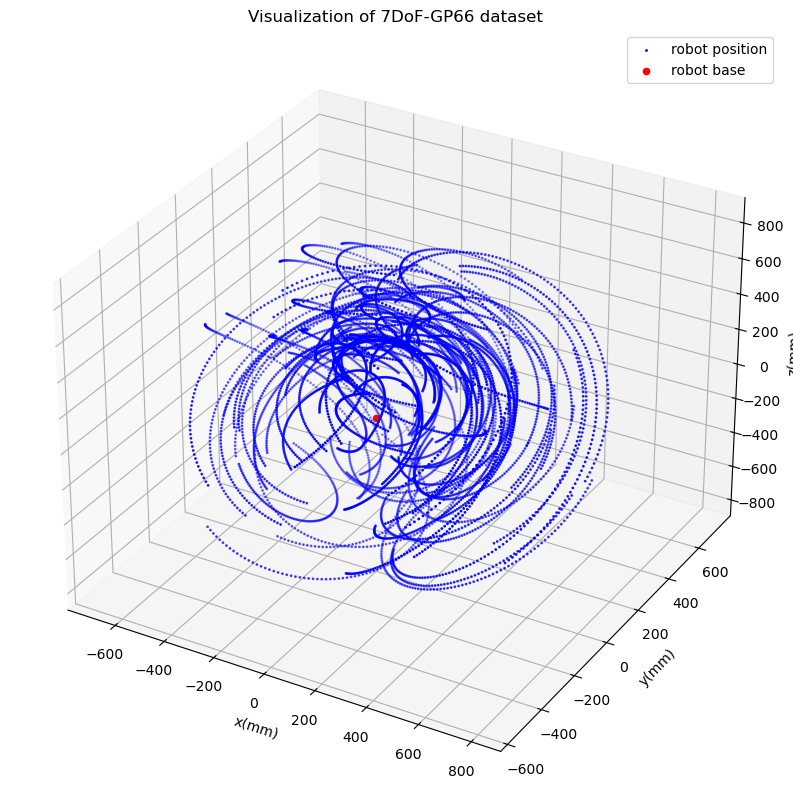

In [60]:
#import ipympl
#import matplotlib.pyplot as plt

vis_traj = 100

### Visualize 4DoF Dataset
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(data_position_a[:vis_traj*100,0], data_position_a[:vis_traj*100,1], data_position_a[:vis_traj*100,2], s=4, c='b', marker='.')
ax.scatter(0,0,0,s=20, marker='o', c='r')
ax.legend(["robot position","robot base"])
ax.set(xlabel='x(mm)', ylabel='y(mm)', zlabel='z(mm)',
       title='Visualization of '+robot_choice+ ' dataset')
#ax.view_init(60, 25)
plt.show()

### Generate Random-based Dataset

In [32]:
"""
(2) 2DoF: = Planar2D, TwoLink
(2) 3DoF: = Planar3R, Planar2RP
(2) 4DoF: = Cobra600 (Scara), Orion5,
(10) 6DoF: = Jaco, Puma560, Mico, IRB140, KR5, UR10, UR3, UR5, Puma260, Stanford
(7) 7DoF: = Jaco2, Panda, GP66+1, WAM, Baxter, Sawyer, Kuka LWR4+, PR2 (Right Arm)
(1) 8DoF: = P8, 
(1) 10DoF: = Ball, Coil 

"""



# seed random generator
torch.manual_seed(0)

# choose robot alongside joint limits
"""

robot_list = ["6DoF-6R-Jaco", "6DoF-6R-Puma560", "6DoF-6R-Mico", "6DoF-6R-IRB140", "6DoF-6R-KR5", 
              "6DoF-6R-UR10", "6DoF-6R-UR3", "6DoF-6R-UR5", "6DoF-6R-Puma260", "6DoF-2RP3R-Stanford"]

robot_list = ["6DoF-6R-Jaco", "6DoF-6R-Puma560", "6DoF-6R-Mico", "6DoF-6R-IRB140", "6DoF-6R-KR5", 
              "6DoF-6R-UR10", "6DoF-6R-UR3", "6DoF-6R-UR5", "6DoF-6R-Puma260", "6DoF-2RP3R-Stanford"]

robot_list = ["6DoF-2RP3R-Stanford"]

"""

robot_list_6 = ["6DoF-6R-Jaco", "6DoF-6R-Puma560", "6DoF-6R-Mico", "6DoF-6R-IRB140", "6DoF-6R-KR5", 
              "6DoF-6R-UR10", "6DoF-6R-UR3", "6DoF-6R-UR5", "6DoF-6R-Puma260", "6DoF-2RP3R-Stanford"]

robot_list_7 = ["7DoF-7R-Jaco2", "7DoF-7R-Panda", "7DoF-7R-WAM", "7DoF-7R-Baxter", "7DoF-7R-Sawyer", 
              "7DoF-7R-KukaLWR4+", "7DoF-7R-PR2Arm", "7DoF-7R-PA10", "7DoF-7R-Gen3", "7DoF-2RP4R-GP66+1"]

#robot_list = robot_list_6 + robot_list_7
robot_list = ["7DoF-7R-Panda"]



#robot_list = ["7DoF-7R-Panda","7DoF-GP66"]
#for js in range(22,52,2):

#for js in range(2,22,2):
for js in range(1,2):
    
    for r in robot_list:

        robot_choice = r
        print('Generating samples for: {}'.format(robot_choice))
        #robot_choice = "7DoF-7R-Panda"  #"7DoF-7R-Panda, "7DoF-GP66", "8DoF-P8"

        if robot_choice == "6DoF-6R-Jaco":
            # https://docs.quanser.com/quarc/documentation/kinova_jaco_read_block.html
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(42)), torch.deg2rad(torch.tensor(318))],
                                  [torch.deg2rad(torch.tensor(17)), torch.deg2rad(torch.tensor(343))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))]])

            robot_type = "C"

        elif robot_choice == "6DoF-6R-Puma560":

            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-160)), torch.deg2rad(torch.tensor(160))],
                                  [torch.deg2rad(torch.tensor(-110)), torch.deg2rad(torch.tensor(110))],
                                  [torch.deg2rad(torch.tensor(-135)), torch.deg2rad(torch.tensor(135))],
                                  [torch.deg2rad(torch.tensor(-266)), torch.deg2rad(torch.tensor(266))],
                                  [torch.deg2rad(torch.tensor(-100)), torch.deg2rad(torch.tensor(100))],
                                  [torch.deg2rad(torch.tensor(-266)), torch.deg2rad(torch.tensor(266))]])

            robot_type = "C"


        elif robot_choice == "6DoF-6R-Mico":
            # https://docs.quanser.com/quarc/documentation/kinova_6dof_mico_write_block.html
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(50)), torch.deg2rad(torch.tensor(310))],
                                  [torch.deg2rad(torch.tensor(25)), torch.deg2rad(torch.tensor(335))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))]])

            robot_type = "C"


        elif robot_choice == "6DoF-6R-IRB140":
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(180))],
                                  [torch.deg2rad(torch.tensor(-100)), torch.deg2rad(torch.tensor(100))],
                                  [torch.deg2rad(torch.tensor(-220)), torch.deg2rad(torch.tensor(60))],
                                  [torch.deg2rad(torch.tensor(-200)), torch.deg2rad(torch.tensor(200))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-400)), torch.deg2rad(torch.tensor(400))]])

            robot_type = "C"


        elif robot_choice == "6DoF-6R-KR5":
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-155)), torch.deg2rad(torch.tensor(155))],
                                  [torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(65))],
                                  [torch.deg2rad(torch.tensor(-15)), torch.deg2rad(torch.tensor(158))],
                                  [torch.deg2rad(torch.tensor(-350)), torch.deg2rad(torch.tensor(350))],
                                  [torch.deg2rad(torch.tensor(-130)), torch.deg2rad(torch.tensor(130))],
                                  [torch.deg2rad(torch.tensor(-350)), torch.deg2rad(torch.tensor(350))]])

            robot_type = "C"


        elif robot_choice == "6DoF-6R-UR10":
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))]])

            robot_type = "C"


        elif robot_choice == "6DoF-6R-UR3":
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))]])

            robot_type = "C"


        elif robot_choice == "6DoF-6R-UR5":
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))]])

            robot_type = "C"


        elif robot_choice == "6DoF-6R-Puma260":
            # https://medesign.seas.upenn.edu/index.php/Guides/PUMA260
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(110))],
                                  [torch.deg2rad(torch.tensor(-75)), torch.deg2rad(torch.tensor(240))],
                                  [torch.deg2rad(torch.tensor(-235)), torch.deg2rad(torch.tensor(60))],
                                  [torch.deg2rad(torch.tensor(-580)), torch.deg2rad(torch.tensor(40))],
                                  [torch.deg2rad(torch.tensor(-30)), torch.deg2rad(torch.tensor(200))],
                                  [torch.deg2rad(torch.tensor(-215)), torch.deg2rad(torch.tensor(295))]])

            robot_type = "C"

        elif robot_choice == "6DoF-2RP3R-Stanford":

            q_lim_o = torch.tensor([[torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.tensor(0.0), torch.tensor(0.8)],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(90))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))]])

            robot_type = "I"
        
        elif robot_choice == "7DoF-7R-Jaco2":    
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(42)), torch.deg2rad(torch.tensor(318))],
                                  [torch.deg2rad(torch.tensor(17)), torch.deg2rad(torch.tensor(343))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))]])

            robot_type = "C" 

        elif robot_choice == "7DoF-7R-Panda":    
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-166)), torch.deg2rad(torch.tensor(166))],
                                      [torch.deg2rad(torch.tensor(-101)), torch.deg2rad(torch.tensor(101))],
                                      [torch.deg2rad(torch.tensor(-166)), torch.deg2rad(torch.tensor(166))],
                                      [torch.deg2rad(torch.tensor(-176)), torch.deg2rad(torch.tensor(-4))],
                                      [torch.deg2rad(torch.tensor(-166)), torch.deg2rad(torch.tensor(166))],
                                      [torch.deg2rad(torch.tensor(-1)), torch.deg2rad(torch.tensor(215))],
                                      [torch.deg2rad(torch.tensor(-166)), torch.deg2rad(torch.tensor(166))]])

            robot_type = "C"


        elif robot_choice == "7DoF-WAM":

            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))]])

            robot_type = "C"

        elif robot_choice == "7DoF-Baxter":

            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-97.5)), torch.deg2rad(torch.tensor(97.5))],
                                  [torch.deg2rad(torch.tensor(-123)), torch.deg2rad(torch.tensor(60))],
                                  [torch.deg2rad(torch.tensor(-175)), torch.deg2rad(torch.tensor(175))],
                                  [torch.deg2rad(torch.tensor(-2.9)), torch.deg2rad(torch.tensor(150))],
                                  [torch.deg2rad(torch.tensor(-175.3)), torch.deg2rad(torch.tensor(175.3))],
                                  [torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-175.3)), torch.deg2rad(torch.tensor(175.3))]])

            robot_type = "C"



        elif robot_choice == "7DoF-7R-Sawyer":

            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-174.7)), torch.deg2rad(torch.tensor(174.7))],
                                  [torch.deg2rad(torch.tensor(-218.3)), torch.deg2rad(torch.tensor(130.2))],
                                  [torch.deg2rad(torch.tensor(-174.3)), torch.deg2rad(torch.tensor(174.3))],
                                  [torch.deg2rad(torch.tensor(-174.4)), torch.deg2rad(torch.tensor(174.4))],
                                  [torch.deg2rad(torch.tensor(-170.5)), torch.deg2rad(torch.tensor(170.5))],
                                  [torch.deg2rad(torch.tensor(-170.5)), torch.deg2rad(torch.tensor(170.5))],
                                  [torch.deg2rad(torch.tensor(-270)), torch.deg2rad(torch.tensor(270))]])

            robot_type = "C"


        elif robot_choice == "7DoF-7R-KukaLWR4+":

            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-175)), torch.deg2rad(torch.tensor(175))]])

            robot_type = "C"


        elif robot_choice == "7DoF-PR2-RightArm":    
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-130)), torch.deg2rad(torch.tensor(40))],
                                  [torch.deg2rad(torch.tensor(60)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-224)), torch.deg2rad(torch.tensor(44))],
                                  [torch.deg2rad(torch.tensor(0)), torch.deg2rad(torch.tensor(133))],
                                  [torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(180))],
                                  [torch.deg2rad(torch.tensor(0)), torch.deg2rad(torch.tensor(130))],
                                  [torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(180))]])

            robot_type = "C"

        elif robot_choice == "7DoF-7R-PA10":

            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(180))],
                                  [torch.deg2rad(torch.tensor(-135)), torch.deg2rad(torch.tensor(135))],
                                  [torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(180))],
                                  [torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(180))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(180))]])

            robot_type = "C"

        elif robot_choice == "7DoF-7R-Gen3":

            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-129)), torch.deg2rad(torch.tensor(129))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-148)), torch.deg2rad(torch.tensor(148))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))],
                                  [torch.deg2rad(torch.tensor(-120)), torch.deg2rad(torch.tensor(120))],
                                  [torch.deg2rad(torch.tensor(-360)), torch.deg2rad(torch.tensor(360))]])

            robot_type = "C"



        elif robot_choice == "7DoF-2RP4R-GP66+1":
            """
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  #[torch.tensor(0.3), torch.tensor(1.27)],
                                  [torch.tensor(-1.27), torch.tensor(-0.3)],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(90))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))],
                                  [torch.deg2rad(torch.tensor(-170)), torch.deg2rad(torch.tensor(170))]])
            """

            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(90))],
                                  [torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(90))],
                                  [torch.tensor(-0.6), torch.tensor(0.7)],
                                  #[torch.tensor(-1.27), torch.tensor(-0.3)],
                                  [torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(90))],
                                  [torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(90))],
                                  [torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(90))],
                                  [torch.deg2rad(torch.tensor(-90)), torch.deg2rad(torch.tensor(90))]])

            robot_type = "I"



        elif robot_choice == "8DoF-P8":    
            q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-1)), torch.deg2rad(torch.tensor(1))],
                                  [torch.deg2rad(torch.tensor(-1)), torch.deg2rad(torch.tensor(1))],
                                  [torch.deg2rad(torch.tensor(-160)), torch.deg2rad(torch.tensor(160))],
                                  [torch.deg2rad(torch.tensor(-110)), torch.deg2rad(torch.tensor(110))],
                                  [torch.deg2rad(torch.tensor(-135)), torch.deg2rad(torch.tensor(135))],
                                  [torch.deg2rad(torch.tensor(-266)), torch.deg2rad(torch.tensor(266))],
                                  [torch.deg2rad(torch.tensor(-100)), torch.deg2rad(torch.tensor(100))],
                                  [torch.deg2rad(torch.tensor(-266)), torch.deg2rad(torch.tensor(266))]])

            robot_type = "I"


        #q_lim = q_lim/scale
        scale = 10
        q_lim = q_lim*(scale/10)

        print("\njoint limits for scale {}:\n{}".format(scale/10, q_lim))

        t0 = torch.distributions.uniform.Uniform(q_lim[:,0], q_lim[:,1]).sample()
        DH = get_DH(robot_choice, t0)
        print('DH:\n', DH)



        print("\njoint range {}:\n".format(js))

        # generate dataset with a specified number of samples
        #n_traj = 10000
        #n_traj_steps = 100
        #n_samples = n_traj*n_traj_steps
        n_samples = 25000000
        print_steps = 1000
        data_position = []


        # # Get the example joint-pose pair
        # #t0 = torch.distributions.uniform.Uniform(q_lim[:,0], q_lim[:,1]).sample()
        # t0 = torch.zeros(7)
        # DH = get_DH(robot_choice, t0)
        # T = forward_kinematics(DH)
        # R = T[:3,:3]       
        # rpy = matrix_to_euler_angles(R, "XYZ") 

        # D_example = torch.cat([T[:3,-1], rpy])
        # Q_example = t0
        
        for s in range(n_samples):
            
            
            # Get the example joint-pose pair
            t0 = torch.distributions.uniform.Uniform(q_lim[:,0], q_lim[:,1]).sample()
            t0 = torch.zeros(7)
            DH = get_DH(robot_choice, t0)
            T = forward_kinematics(DH)
            R = T[:3,:3]       
            rpy = matrix_to_euler_angles(R, "XYZ") 
    
            D_example = torch.cat([T[:3,-1], rpy])
            Q_example = t0

            # Get the query joint-pose pair
            t = torch.distributions.uniform.Uniform(q_lim[:,0], q_lim[:,1]).sample()
            DH = get_DH(robot_choice, t)
            T = forward_kinematics(DH)
            R = T[:3,:3]       
            rpy = matrix_to_euler_angles(R, "XYZ")  

            D_query = torch.cat([T[:3,-1], rpy])
            Q_query = t

            # Save both in a list
            data_position.append(torch.cat([D_example, Q_example, D_query, Q_query]).numpy())
            

            if s%(n_samples/print_steps) == 0:
                print("Generated [{}] samples...".format(s))

        data_position_a = np.array(data_position)

        # save dataset
        #if robot_choice == "6DoF-7R-Panda" or "7DoF-GP66":
        """
        header = ["x_p", "y_p", "z_p","R_p","P_p","Y_p",
                  "t1_p", "t2_p", "t3_p", "t4_p", "t5_p", "t6_p", 
                  "x_c", "y_c", "z_c","R_c","P_c","Y_c",
                  "t1_c", "t2_c", "t3_c", "t4_c", "t5_c", "t6_c"]
        """

        if robot_choice in robot_list_6:
            header = ["x_p", "y_p", "z_p","R_p","P_p","Y_p",
                      "t1_p", "t2_p", "t3_p", "t4_p", "t5_p", "t6_p",
                      "x_c", "y_c", "z_c","R_c","P_c","Y_c",
                      "t1_c", "t2_c", "t3_c", "t4_c", "t5_c", "t6_c"]


        elif robot_choice in robot_list_7:
            header = ["x_p", "y_p", "z_p","R_p","P_p","Y_p",
                      "t1_p", "t2_p", "t3_p", "t4_p", "t5_p", "t6_p", "t7_p",
                      "x_c", "y_c", "z_c","R_c","P_c","Y_c",
                      "t1_c", "t2_c", "t3_c", "t4_c", "t5_c", "t6_c", "t7_c"]


        """    
        if robot_choice == "7DoF-7R-Panda" or robot_choice == "7DoF-GP66":
            header = ["x_p", "y_p", "z_p","R_p","P_p","Y_p",
                      "t1_p", "t2_p", "t3_p", "t4_p", "t5_p", "t6_p", "t7_p",
                      "x_c", "y_c", "z_c","R_c","P_c","Y_c",
                      "t1_c", "t2_c", "t3_c", "t4_c", "t5_c", "t6_c", "t7_c"]

        if robot_choice =="8DoF-P8":
            header = ["x_p", "y_p", "z_p","R_p","P_p","Y_p",
                      "t1_p", "t2_p", "t3_p", "t4_p", "t5_p", "t6_p", "t7_p", "t8_p",
                      "x_c", "y_c", "z_c","R_c","P_c","Y_c",
                      "t1_c", "t2_c", "t3_c", "t4_c", "t5_c", "t6_c", "t7_c", "t8_c"]
        """


        df = pd.DataFrame(data_position_a)
        n_samples = data_position_a.shape[0]

        """
        path = "~/Documents/Research/WCCI2024/"
        df.to_csv(path+"datasets/"+robot_choice+"/data_"+robot_choice+"_"+str(n_samples)+"_qlim_scale_"+str(int(scale))+"_seq.csv",
                  index=False,
                  header=header)
        """

        df = pd.DataFrame(data_position_a)  # "datasets/"+robot_choice+"/
        df.to_csv("traj_steps_rand/review_data_"+robot_choice+"_"+str(n_samples)+"_qlim_scale_"+str(int(scale))+"_seq_"+str(js)+".csv", index=False, header=header)



        data_position_a[:,:3] = data_position_a[:,:3] * 1000
        data_position_a[:,13:16] = data_position_a[:,13:16] * 1000

        print("Data generation done for {}! - {} samples with {} joint step\n".format(robot_choice, n_samples, js))

Generating samples for: 7DoF-7R-Panda

joint limits for scale 1.0:
tensor([[-2.8972,  2.8972],
        [-1.7628,  1.7628],
        [-2.8972,  2.8972],
        [-3.0718, -0.0698],
        [-2.8972,  2.8972],
        [-0.0175,  3.7525],
        [-2.8972,  2.8972]])
DH:
 tensor([[-0.0217,  0.3330,  0.0000,  0.0000],
        [ 0.9456,  0.0000,  0.0000, -1.5708],
        [-2.3846,  0.3160,  0.0000,  1.5708],
        [-2.6754,  0.0000,  0.0825,  1.5708],
        [-1.1159,  0.3840, -0.0825, -1.5708],
        [ 2.3730,  0.0000,  0.0000,  1.5708],
        [-0.0574,  0.1070,  0.0880,  1.5708]])

joint range 1:

Generated [0] samples...
Generated [25000] samples...
Generated [50000] samples...
Generated [75000] samples...
Generated [100000] samples...
Generated [125000] samples...
Generated [150000] samples...
Generated [175000] samples...
Generated [200000] samples...
Generated [225000] samples...
Generated [250000] samples...
Generated [275000] samples...
Generated [300000] samples...
Generated

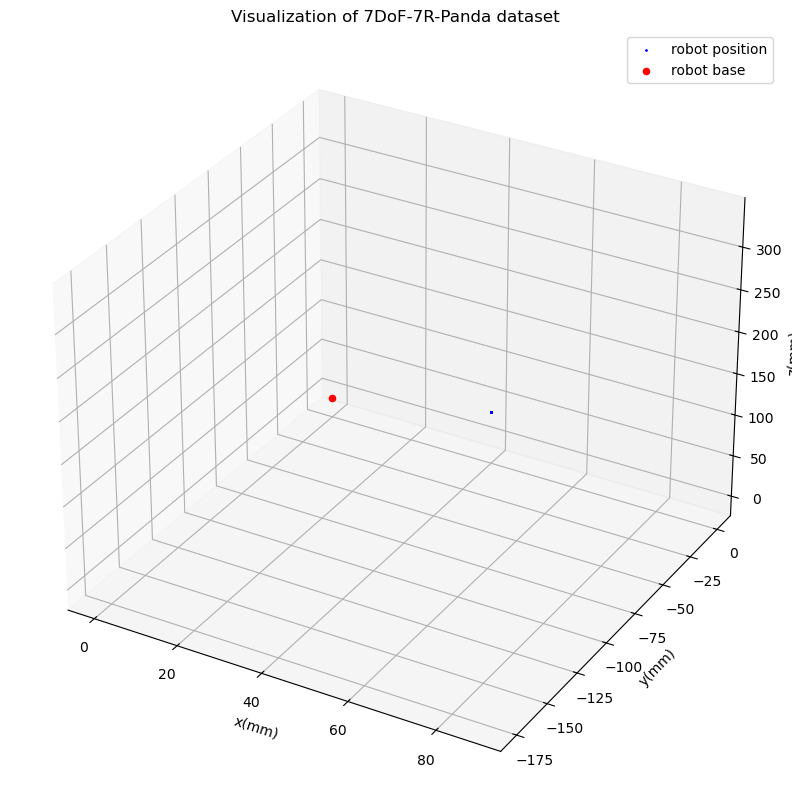

In [29]:
#import ipympl
#import matplotlib.pyplot as plt

vis_samples = 1000000
#data_position_a[:,0:3] = data_position_a[:,0:3] * 1000
#data_position_a[:,13:16] = data_position_a[:,13:16] * 1000


### Visualize 4DoF Dataset
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(data_position_a[:vis_samples,0], data_position_a[:vis_samples,1], data_position_a[:vis_samples,2], s=4, c='b', marker='.')
ax.scatter(0,0,0,s=20, marker='o', c='r')
ax.legend(["robot position","robot base"])
ax.set(xlabel='x(mm)', ylabel='y(mm)', zlabel='z(mm)',
       title='Visualization of '+robot_choice+ ' dataset')
#ax.view_init(60, 25)
plt.show()

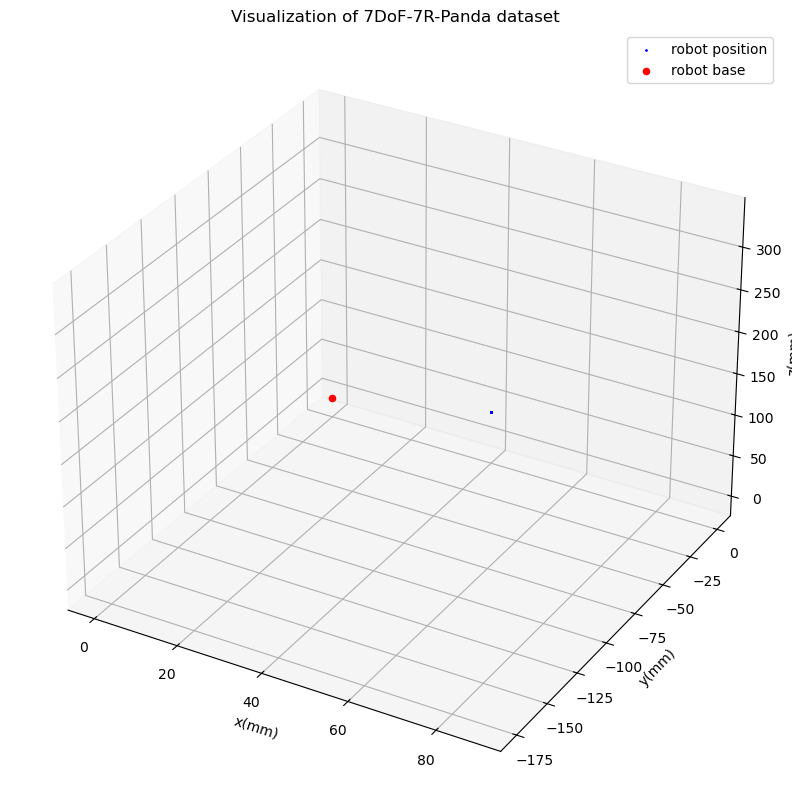

In [31]:
#import ipympl
#import matplotlib.pyplot as plt

vis_samples = 1000000

### Visualize 4DoF Dataset
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(data_position_a[:vis_samples,0], data_position_a[:vis_samples,1], data_position_a[:vis_samples,2], s=4, c='b', marker='.')
#ax.scatter(data_position_a[:vis_samples,13], data_position_a[:vis_samples,14], data_position_a[:vis_samples,15], s=4, c='r', marker='*')
ax.scatter(0,0,0,s=20, marker='o', c='r')
ax.legend(["robot position","robot base"])
ax.set(xlabel='x(mm)', ylabel='y(mm)', zlabel='z(mm)',
       title='Visualization of '+robot_choice+ ' dataset')
#ax.view_init(60, 25)
plt.show()